In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, accuracy_score)
from sklearn.cluster import KMeans
import warnings

from IPython.display import Markdown

In [6]:
df = pd.read_csv('BankChurners.csv')
df['Churn'] = (df['Attrition_Flag'] == 'Attrited Customer').astype(int)

In [7]:
# Creating new features that might predict churn
display(Markdown("\n **FEATURE ENGINEERING**"))
display(Markdown("\n Creating new predictive features"))


# 1. Engagement Score (transactions per month on book)
df['Engagement_Score'] = df['Total_Trans_Ct'] / df['Months_on_book']

# 2. Inactivity Rate
df['Inactivity_Rate'] = df['Months_Inactive_12_mon'] / 12

# 3. Credit Utilization Category
df['High_Utilization'] = (df['Avg_Utilization_Ratio'] > 0.7).astype(int)

# 4. Low Transaction Flag
df['Low_Transaction'] = (df['Total_Trans_Ct'] < 50).astype(int)

# 5. Product Concentration (fewer products = higher risk)
df['Few_Products'] = (df['Total_Relationship_Count'] <= 2).astype(int)

# 6. Spending Momentum (transaction change Q4 vs Q1)
df['Declining_Spending'] = (df['Total_Amt_Chng_Q4_Q1'] < 0.7).astype(int)

display(Markdown("**Definitions**"))
print("   Engagement Score = Transactions per month")
print("   Inactivity Rate = Percentage of year inactive ")
print("   High Utilization = >70% credit used")
print("   Low Transaction = <50 transactions made")
print("   Few Products = ≤2 products bought")
print("   Declining Spending = Q4 vs Q1 decrease in spending \n")


# Correlation of new features
display(Markdown("\n **New Features - Correlation with Churn:**"))

new_features = ['Engagement_Score', 'Inactivity_Rate', 'High_Utilization',
                'Low_Transaction', 'Few_Products', 'Declining_Spending']

for feature in new_features:
    corr = df[[feature, 'Churn']].corr().iloc[0, 1]
    print(f"   {feature:<25} {corr:>+.4f}")


 **FEATURE ENGINEERING**


 Creating new predictive features

**Definitions**

   Engagement Score = Transactions per month
   Inactivity Rate = Percentage of year inactive 
   High Utilization = >70% credit used
   Low Transaction = <50 transactions made
   Few Products = ≤2 products bought
   Declining Spending = Q4 vs Q1 decrease in spending 




 **New Features - Correlation with Churn:**

   Engagement_Score          -0.2872
   Inactivity_Rate           +0.1524
   High_Utilization          -0.0291
   Low_Transaction           +0.3909
   Few_Products              +0.1532
   Declining_Spending        +0.0821


In [15]:
display(Markdown("\n **PREPARING DATA FOR MACHINE LEARNING**"))

# Encoding categorical variables
print("Encoding categorical variables")
categorical_cols = ['Gender', 'Education_Level', 'Marital_Status', 
                    'Income_Category', 'Card_Category']

le = LabelEncoder()
for col in categorical_cols:
    df[col + '_Encoded'] = le.fit_transform(df[col])
    print(f"    Encoded {col}")




 **PREPARING DATA FOR MACHINE LEARNING**

Encoding categorical variables
    Encoded Gender
    Encoded Education_Level
    Encoded Marital_Status
    Encoded Income_Category
    Encoded Card_Category


In [17]:
# Selecting features for modeling
print("Selecting features for prediction")

# Original features
original_features = ['Customer_Age', 'Dependent_count', 'Months_on_book',
                     'Total_Relationship_Count', 'Months_Inactive_12_mon',
                     'Contacts_Count_12_mon', 'Credit_Limit', 
                     'Total_Revolving_Bal', 'Total_Trans_Amt', 
                     'Total_Trans_Ct', 'Avg_Utilization_Ratio']

# Encoded categorical features
encoded_features = [col + '_Encoded' for col in categorical_cols]

# New engineered features
engineered_features = ['Engagement_Score', 'Inactivity_Rate', 
                       'High_Utilization', 'Low_Transaction', 
                       'Few_Products', 'Declining_Spending']

# Combining all features
all_features = original_features + encoded_features + engineered_features

print(f"   Total features selected: {len(all_features)}")
print(f"      - Original: {len(original_features)}")
print(f"      - Categorical (encoded): {len(encoded_features)}")
print(f"      - Engineered: {len(engineered_features)}")



Selecting features for prediction
   Total features selected: 22
      - Original: 11
      - Categorical (encoded): 5
      - Engineered: 6


In [24]:
# Preparing X and y
X = df[all_features]
y = df['Churn']

# Split data
print("Splitting data (80% for training, 20% for testing)")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\n  Training set:")
print(f"    Training set: {len(X_train):,} customers")
print(f"    Churn rate in train: {y_train.mean()*100:.2f}%")

print("\n  Testing set:")
print(f"    Testing set: {len(X_test):,} customers")
print(f"    Churn rate in test: {y_test.mean()*100:.2f}%")



Splitting data (80% for training, 20% for testing)

  Training set:
    Training set: 8,101 customers
    Churn rate in train: 16.07%

  Testing set:
    Testing set: 2,026 customers
    Churn rate in test: 16.04%


In [28]:
# Standardizing features
print("Standardizing features")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("   Features standardized (mean=0, std=1)")

Standardizing features
   Features standardized (mean=0, std=1)


In [32]:
# Training Logistic Regression
display(Markdown("\n **MODEL 01: LOGISTIC REGRESSION**"))

# Training model
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_scaled, y_train)
print("Model trained successfully!")



 **MODEL 01: LOGISTIC REGRESSION**

Model trained successfully!


In [43]:
# Making predictions
print("\nMaking predictions")
y_pred_log = log_model.predict(X_test_scaled)
y_pred_prob_log = log_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("\nModel Performance:")
print("-" * 80)

accuracy = accuracy_score(y_test, y_pred_log)
auc = roc_auc_score(y_test, y_pred_prob_log)

print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"\nAUC Score: {auc:.4f}")
print("\n")

if auc > 0.90:
    display(Markdown("**EXCELLENT - Outstanding Predictive Power!**"))
elif auc > 0.80:
    display(Markdown("**VERY GOOD - Strong Predictive Ability!**"))
elif auc > 0.70:
     display(Markdown("**GOOD - Decent Predictive Performance**"))
else:
    display(Markdown("**FAIR - Needs Improvement**"))

print("-" * 80)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_log, 
                          target_names=['Retained', 'Churned']))



Making predictions

Model Performance:
--------------------------------------------------------------------------------
Accuracy: 0.8968 (89.68%)

AUC Score: 0.9033




**EXCELLENT - Outstanding Predictive Power!**

--------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

    Retained       0.91      0.97      0.94      1701
     Churned       0.77      0.51      0.61       325

    accuracy                           0.90      2026
   macro avg       0.84      0.74      0.78      2026
weighted avg       0.89      0.90      0.89      2026



In [45]:
# Feature importance
display(Markdown("**TOP 15 MOST IMPORTANT FEATURES AND THEIR COEFFICIENT:**"))

feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': np.abs(log_model.coef_[0])
}).sort_values('Coefficient', ascending=False)

for i, row in feature_importance.head(15).iterrows():
    print(f"   {row['Feature']:<35} {row['Coefficient']:.4f}")

**TOP 15 MOST IMPORTANT FEATURES AND THEIR COEFFICIENT:**

   Total_Trans_Ct                      2.3628
   Total_Trans_Amt                     1.3120
   Few_Products                        0.6571
   Total_Revolving_Bal                 0.6479
   Contacts_Count_12_mon               0.6301
   Avg_Utilization_Ratio               0.5297
   High_Utilization                    0.4636
   Gender_Encoded                      0.3588
   Engagement_Score                    0.2850
   Total_Relationship_Count            0.2794
   Inactivity_Rate                     0.2550
   Months_Inactive_12_mon              0.2550
   Months_on_book                      0.1981
   Marital_Status_Encoded              0.1964
   Dependent_count                     0.1946


In [47]:
# Training Random Forest
display(Markdown("**MODEL 02: RANDOM FOREST CLASSIFIER**"))

rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, 
                                  random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
print("   Model trained successfully!")

**MODEL 02: RANDOM FOREST CLASSIFIER**

   Model trained successfully!


In [52]:
# Making predictions
print("\nMaking predictions")

y_pred_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate
print("\nModel performance:")
print("-" * 80)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_prob_rf)

print(f"Accuracy: {accuracy_rf:.4f} ({accuracy_rf*100:.2f}%)")
print(f"\nAUC Score: {auc_rf:.4f}")
print("\n")

if auc_rf > 0.90:
    display(Markdown("**EXCELLENT - Outstanding Predictive Power!**"))
elif auc_rf > 0.80:
    display(Markdown("**VERY GOOD - Strong Predictive Ability!**"))
elif auc_rf > 0.70:
    display(Markdown("**GOOD - Decent Predictive Performance**"))
else:
    display(Markdown("**FAIR - Needs Improvement**"))


print("-" * 80)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, 
                          target_names=['Retained', 'Churned']))




Making predictions

Model performance:
--------------------------------------------------------------------------------
Accuracy: 0.9388 (93.88%)

AUC Score: 0.9755




**EXCELLENT - Outstanding Predictive Power!**

--------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

    Retained       0.95      0.98      0.96      1701
     Churned       0.89      0.70      0.79       325

    accuracy                           0.94      2026
   macro avg       0.92      0.84      0.88      2026
weighted avg       0.94      0.94      0.94      2026



In [57]:
# Feature importance
display(Markdown("**TOP 15 MOST IMPORTANT FEATURES AND THEIR IMPORTANCE PERCENTAGE:**"))


feature_importance_rf = pd.DataFrame({
    'Feature': all_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

for i, row in feature_importance_rf.head(15).iterrows():
    # Calculate percentage
    importance_pct = row['Importance'] * 100
    print(f"   {row['Feature']:<35} {row['Importance']:.4f} ({importance_pct:.2f}%)")

# Identify the most important feature
top_feature = feature_importance_rf.iloc[0]
print(f"\n{top_feature['Feature']}, is the number one predictor and it accounts for {top_feature['Importance']*100:.2f}% of prediction power.")

**TOP 15 MOST IMPORTANT FEATURES AND THEIR IMPORTANCE PERCENTAGE:**

   Total_Trans_Amt                     0.1844 (18.44%)
   Total_Trans_Ct                      0.1581 (15.81%)
   Total_Revolving_Bal                 0.1129 (11.29%)
   Engagement_Score                    0.0822 (8.22%)
   Avg_Utilization_Ratio               0.0793 (7.93%)
   Low_Transaction                     0.0638 (6.38%)
   Total_Relationship_Count            0.0624 (6.24%)
   Few_Products                        0.0420 (4.20%)
   Credit_Limit                        0.0325 (3.25%)
   Contacts_Count_12_mon               0.0300 (3.00%)
   Customer_Age                        0.0272 (2.72%)
   Months_on_book                      0.0212 (2.12%)
   Months_Inactive_12_mon              0.0211 (2.11%)
   Inactivity_Rate                     0.0211 (2.11%)
   Gender_Encoded                      0.0107 (1.07%)

Total_Trans_Amt, is the number one predictor and it accounts for 18.44% of prediction power.


In [59]:
# Model comparison
display(Markdown("**MODEL COMPARISION**"))
print("Logistic Regression Vs Random Forest ")


**MODEL COMPARISION**

Logistic Regression Vs Random Forest 


**Performance Comparison:**


              Model  Accuracy  AUC Score
Logistic Regression  0.896841   0.903322
      Random Forest  0.938796   0.975475

 Best suitable model: Random Forest
   Advantage: 0.0722 AUC points




**ROC curves**

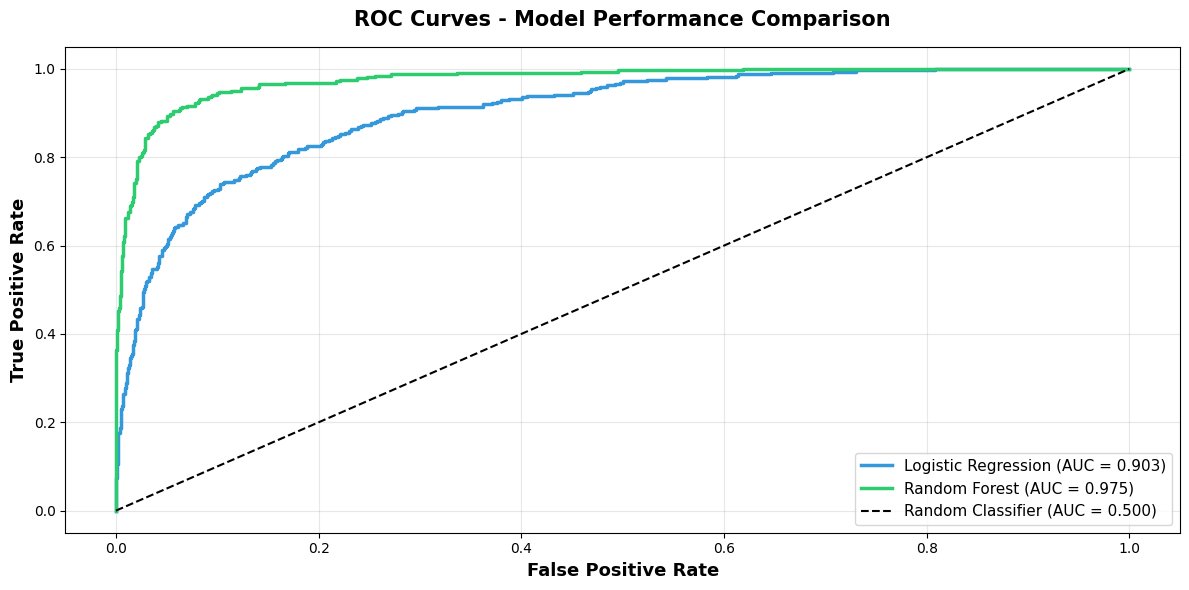


 Interpretation:
   • The curve closer to the top left corner is the better model
   • AUC  means the Area Under the Curve (0.5 = random, 1.0 = perfect)
   • Our best model has 97.5% accuracy in ranking customers by churn risk


In [68]:
# Comparison table
comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [accuracy, accuracy_rf],
    'AUC Score': [auc, auc_rf]
})

display(Markdown("**Performance Comparison:**\n"))
print(comparison.to_string(index=False))

# Determine winner
if auc_rf > auc:
    winner = "Random Forest"
    advantage = auc_rf - auc
else:
    winner = "Logistic Regression"
    advantage = auc - auc

print(f"\n Best suitable model: {winner}")
print(f"   Advantage: {advantage:.4f} AUC points")

# Visualize ROC Curves
print("\n")
display(Markdown("**ROC curves**"))

from sklearn.metrics import roc_curve

fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)

plt.figure(figsize=(12, 6))

# Plot ROC curves
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {auc:.3f})', 
         linewidth=2.5, color='#3498db')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})', 
         linewidth=2.5, color='#2ecc71')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.500)', 
         linewidth=1.5)

# Customize
plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
plt.title('ROC Curves - Model Performance Comparison', 
          fontsize=15, fontweight='bold', pad=15)
plt.legend(fontsize=11, loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n Interpretation:")
print("   • The curve closer to the top left corner is the better model")
print("   • AUC  means the Area Under the Curve (0.5 = random, 1.0 = perfect)")
print(f"   • Our best model has {max(auc, auc_rf):.1%} accuracy in ranking customers by churn risk")

**Comparing feature importance across models**

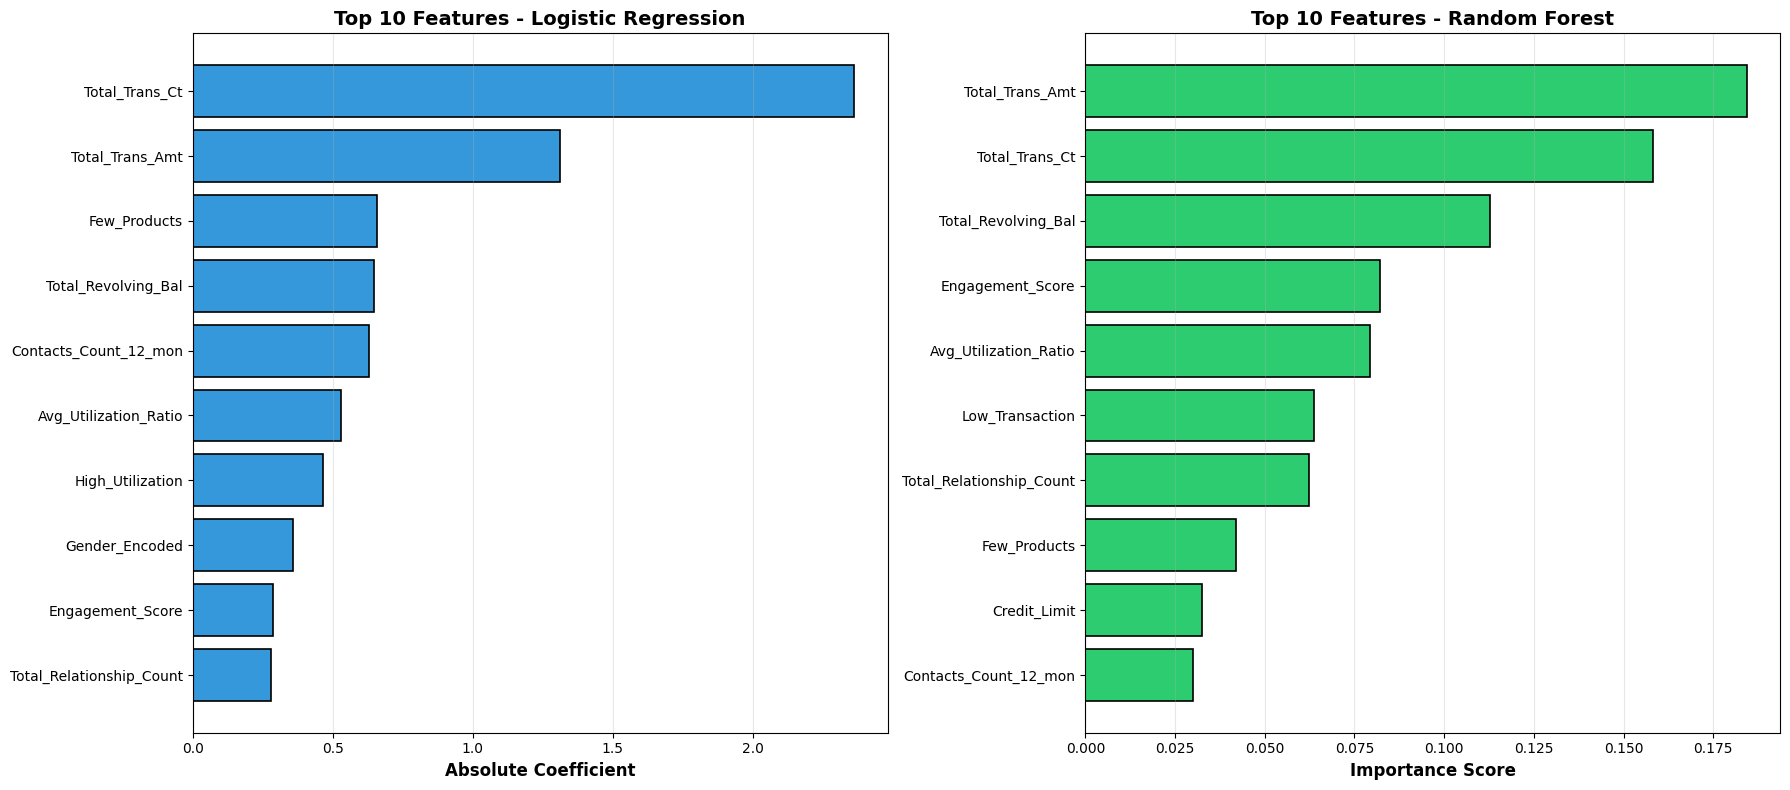


Key Observations:

  The features in top 5 of both the models:
   • Total_Trans_Amt
   • Total_Trans_Ct
   • Total_Revolving_Bal


In [74]:
display(Markdown("**Comparing feature importance across models**"))

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Logistic Regression - Top 10
top_10_log = feature_importance.head(10).sort_values('Coefficient')
axes[0].barh(top_10_log['Feature'], top_10_log['Coefficient'], 
             color='#3498db', edgecolor='black', linewidth=1.2)
axes[0].set_xlabel('Absolute Coefficient', fontsize=12, fontweight='bold')
axes[0].set_title('Top 10 Features - Logistic Regression', 
                  fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Random Forest - Top 10
top_10_rf = feature_importance_rf.head(10).sort_values('Importance')
axes[1].barh(top_10_rf['Feature'], top_10_rf['Importance'], 
             color='#2ecc71', edgecolor='black', linewidth=1.2)
axes[1].set_xlabel('Importance Score', fontsize=12, fontweight='bold')
axes[1].set_title('Top 10 Features - Random Forest', 
                  fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Observations:")

# Find common top features
log_top_5 = set(feature_importance.head(5)['Feature'])
rf_top_5 = set(feature_importance_rf.head(5)['Feature'])
common_features = log_top_5.intersection(rf_top_5)

print(f"\n  The features in top 5 of both the models:")
for feature in common_features:
    print(f"   • {feature}")


**CONFUSION MATRIX ANALYSIS**

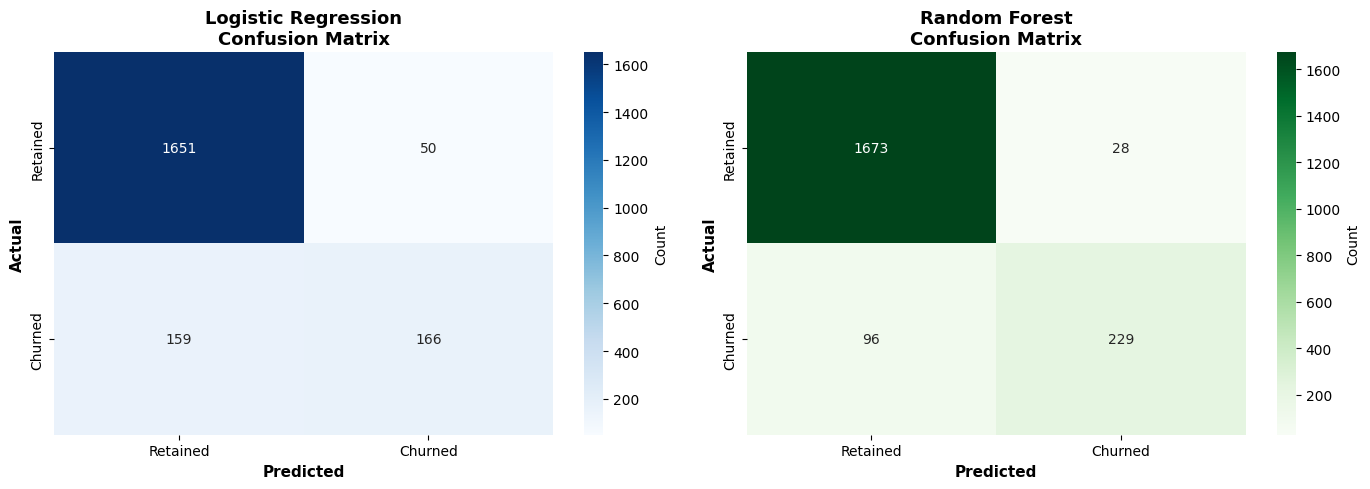

--------------------------------------------------------------------------------

Confusion Matrix Breakdown - Random Forest:

   True Negatives (TN): 1,673
      Correctly predicted as RETAINED: 1673

   True Positives (TP): 229
      Correctly predicted as CHURNED: 229

   False Positives (FP): 28
      Predicted CHURNED but actually RETAINED
      Impact: Wasted retention effort on loyal customers

   False Negatives (FN): 96
      Predicted RETAINED but actually CHURNED
      Impact: Missed opportunity to save at risk customers!

--------------------------------------------------------------------------------

Key Metrics:

   Precision: 89.11% of predicted churners, 89% actually churned.
   Recall: 70.46% we found 70% of actual churners.
   F1-Score: 0.787


In [84]:
display(Markdown("**CONFUSION MATRIX ANALYSIS**"))

# Confusion matrices
cm_log = confusion_matrix(y_test, y_pred_log)
cm_rf = confusion_matrix(y_test, y_pred_rf)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Logistic Regression
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Retained', 'Churned'],
            yticklabels=['Retained', 'Churned'],
            cbar_kws={'label': 'Count'})
axes[0].set_title('Logistic Regression\nConfusion Matrix', 
                  fontsize=13, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=11, fontweight='bold')

# Random Forest
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Retained', 'Churned'],
            yticklabels=['Retained', 'Churned'],
            cbar_kws={'label': 'Count'})
axes[1].set_title('Random Forest\nConfusion Matrix', 
                  fontsize=13, fontweight='bold')
axes[1].set_ylabel('Actual', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("-" * 80)

# Results
print("\nConfusion Matrix Breakdown - Random Forest:")

tn, fp, fn, tp = cm_rf.ravel()

print(f"\n   True Negatives (TN): {tn:,}")
print(f"      Correctly predicted as RETAINED: {tn}")

print(f"\n   True Positives (TP): {tp:,}")
print(f"      Correctly predicted as CHURNED: {tp}")

print(f"\n   False Positives (FP): {fp:,}")
print(f"      Predicted CHURNED but actually RETAINED")
print(f"      Impact: Wasted retention effort on loyal customers")

print(f"\n   False Negatives (FN): {fn:,}")
print(f"      Predicted RETAINED but actually CHURNED")
print(f"      Impact: Missed opportunity to save at risk customers!\n")

print("-" * 80)

# Calculating metrics
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"\nKey Metrics:")
print(f"\n   Precision: {precision:.2%} of predicted churners, {precision:.0%} actually churned.")
print(f"   Recall: {recall:.2%} we found {recall:.0%} of actual churners.")
print(f"   F1-Score: {f1_score:.3f}")

In [100]:
# Segmenting customers by risk level
display(Markdown("**CUSTOMER RISK SEGMENTATION**"))

print("Objective: To group customers into distinct risk segments")

# Features for clustering
cluster_features = ['Total_Trans_Ct', 'Months_Inactive_12_mon', 
                    'Total_Relationship_Count', 'Contacts_Count_12_mon',
                    'Engagement_Score']

X_cluster = df[cluster_features].copy()

# Standardizing
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

# K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['Risk_Segment'] = kmeans.fit_predict(X_cluster_scaled)
print("\n")
display(Markdown("**K-Means Clustering (4 segments)**"))

# Analyzing segments
print("Segment Characteristics:")

segment_analysis = df.groupby('Risk_Segment').agg({
    'Total_Trans_Ct': 'mean',
    'Months_Inactive_12_mon': 'mean',
    'Total_Relationship_Count': 'mean',
    'Engagement_Score': 'mean',
    'Churn': ['sum', 'mean', 'count']
}).round(2)

# Flatten column names
segment_analysis.columns = ['Avg_Transactions', 'Avg_Inactive_Months', 
                            'Avg_Products', 'Avg_Engagement',
                            'Total_Churned', 'Churn_Rate', 'Segment_Size']

# Calculate churn rate as percentage
segment_analysis['Churn_Rate'] = (segment_analysis['Churn_Rate'] * 100).round(2)

# Identify segments by risk level
segment_analysis['Risk_Level'] = segment_analysis['Churn_Rate'].apply(
    lambda x: ' CRITICAL' if x > 40 
    else ' HIGH' if x > 25 
    else ' MEDIUM' if x > 15 
    else ' LOW'
)

# Reorder columns for better display
display_cols = ['Segment_Size', 'Churn_Rate', 'Total_Churned', 'Risk_Level',
                'Avg_Transactions', 'Avg_Inactive_Months', 'Avg_Products', 'Avg_Engagement']
segment_display = segment_analysis[display_cols].copy()

# Rename for better readability
segment_display.columns = ['Size', 'Churn %', 'Churned', 'Risk Level',
                           'Avg Trans', 'Avg Inactive', 'Avg Products', 'Avg Engagement']

detailed_summary = []
for seg, row in segment_analysis.iterrows():
    detailed_summary.append({
        'Segment': f'Segment {seg}',
        'Risk Level': row['Risk_Level'],
        'Size': f"{int(row['Segment_Size']):,}",
        'Churn Rate': f"{row['Churn_Rate']:.1f}%",
        'Total Churned': f"{int(row['Total_Churned'])}",
        'Avg Transactions': f"{row['Avg_Transactions']:.0f}",
        'Avg Inactive Months': f"{row['Avg_Inactive_Months']:.2f}",
        'Avg Products': f"{row['Avg_Products']:.2f}"
    })

detailed_df = pd.DataFrame(detailed_summary)
display(detailed_df.style.set_properties(**{
    'text-align': 'center',
    'border': '1px solid black'
}))

**CUSTOMER RISK SEGMENTATION**

Objective: To group customers into distinct risk segments




**K-Means Clustering (4 segments)**

Segment Characteristics:


,Segment,Risk Level,Size,Churn Rate,Total Churned,Avg Transactions,Avg Inactive Months,Avg Products
0,Segment 0,HIGH,"3,062",40.0%,1223,38,2.42,3.83
1,Segment 1,LOW,"2,251",9.0%,203,71,3.42,4.46
2,Segment 2,LOW,"2,619",4.0%,109,69,1.51,4.68
3,Segment 3,LOW,"2,195",4.0%,92,91,2.11,2.08


In [107]:
print("KEY INSIGHTS:")

# Highest and lowest risk segments
highest_risk_seg = segment_analysis['Churn_Rate'].idxmax()
lowest_risk_seg = segment_analysis['Churn_Rate'].idxmin()

print(f"\n HIGHEST RISK: Segment {highest_risk_seg}")
print(f"   • Churn Rate: {segment_analysis.loc[highest_risk_seg, 'Churn_Rate']:.1f}%")
print(f"   • Size: {int(segment_analysis.loc[highest_risk_seg, 'Segment_Size']):,} customers")
print(f"   • Total Churned: {int(segment_analysis.loc[highest_risk_seg, 'Total_Churned'])} customers")
print(f"   • Avg Transactions: {segment_analysis.loc[highest_risk_seg, 'Avg_Transactions']:.0f}")
print(f"   • Avg Inactive Months: {segment_analysis.loc[highest_risk_seg, 'Avg_Inactive_Months']:.2f}")

print(f"\n LOWEST RISK: Segment {lowest_risk_seg}")
print(f"   • Churn Rate: {segment_analysis.loc[lowest_risk_seg, 'Churn_Rate']:.1f}%")
print(f"   • Size: {int(segment_analysis.loc[lowest_risk_seg, 'Segment_Size']):,} customers")
print(f"   • Avg Transactions: {segment_analysis.loc[lowest_risk_seg, 'Avg_Transactions']:.0f}")
print(f"   • Avg Inactive Months: {segment_analysis.loc[lowest_risk_seg, 'Avg_Inactive_Months']:.2f}")

# Customers needing immediate attention
high_risk_customers = segment_analysis[segment_analysis['Churn_Rate'] > 25]['Segment_Size'].sum()
print(f"\nImmediate action required for the customers in HIGH/CRITICAL risk segments, which is for {int(high_risk_customers):,} customers.These customers need proactive retention campaigns.")


KEY INSIGHTS:

 HIGHEST RISK: Segment 0
   • Churn Rate: 40.0%
   • Size: 3,062 customers
   • Total Churned: 1223 customers
   • Avg Transactions: 38
   • Avg Inactive Months: 2.42

 LOWEST RISK: Segment 2
   • Churn Rate: 4.0%
   • Size: 2,619 customers
   • Avg Transactions: 69
   • Avg Inactive Months: 1.51

Immediate action required for the customers in HIGH/CRITICAL risk segments, which is for 3,062 customers.These customers need proactive retention campaigns.


**Visualizing customer segments**

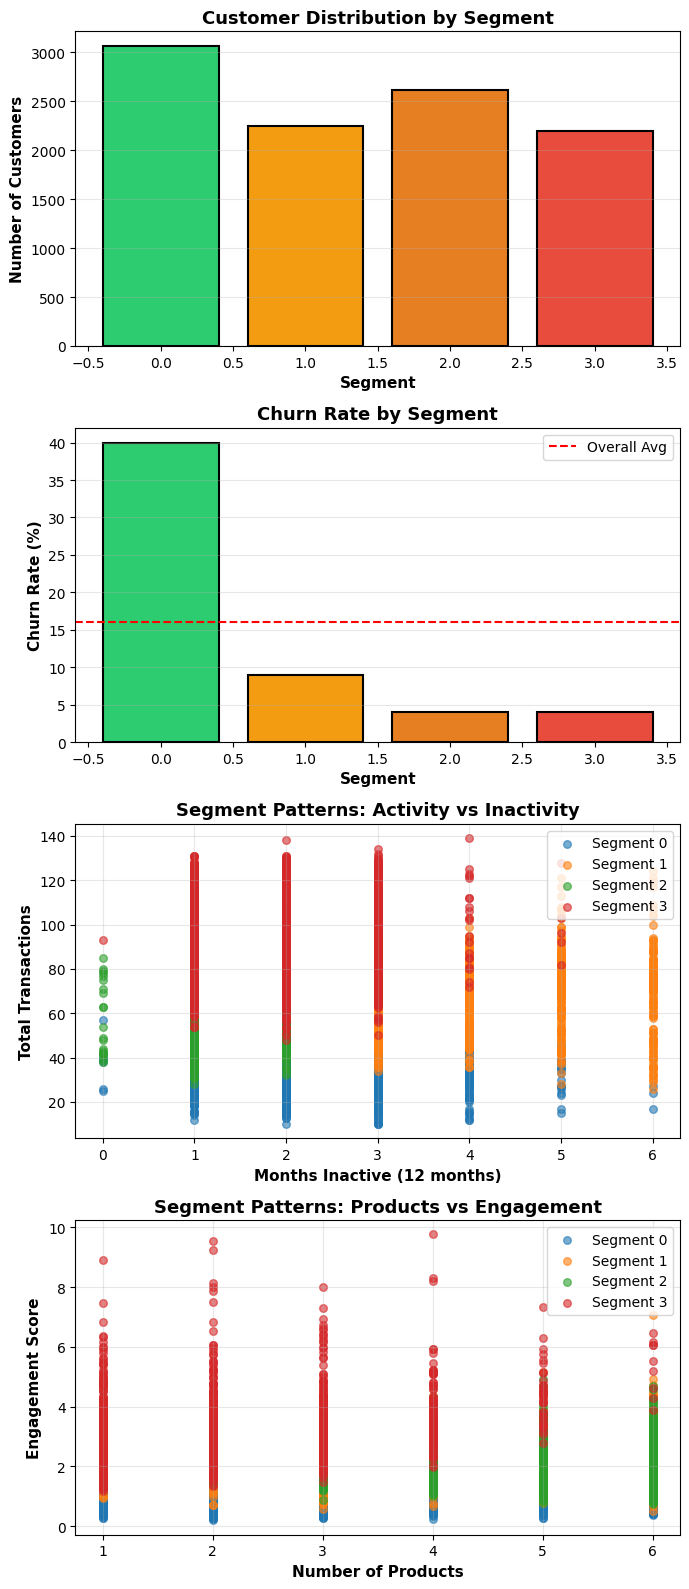

In [114]:
display(Markdown("**Visualizing customer segments**"))

fig, axes = plt.subplots(4, 1, figsize=(7, 16))

# 1: Segment Distribution

axes[0].bar(segment_analysis.index, segment_analysis['Segment_Size'],
            color=['#2ecc71', '#f39c12', '#e67e22', '#e74c3c'],
            edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('Segment', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Number of Customers', fontsize=11, fontweight='bold')
axes[0].set_title('Customer Distribution by Segment', 
                  fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# 2: Churn Rate by Segment
axes[1].bar(segment_analysis.index, segment_analysis['Churn_Rate'],
            color=['#2ecc71', '#f39c12', '#e67e22', '#e74c3c'],
            edgecolor='black', linewidth=1.5)
axes[1].set_xlabel('Segment', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Churn Rate (%)', fontsize=11, fontweight='bold')
axes[1].set_title('Churn Rate by Segment', 
                  fontsize=13, fontweight='bold')
axes[1].axhline(y=df['Churn'].mean()*100, color='red', 
                linestyle='--', label='Overall Avg')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# 3: Transactions vs Inactive Months 
for seg in range(4):
    seg_data = df[df['Risk_Segment'] == seg]
    axes[2].scatter(seg_data['Months_Inactive_12_mon'], 
                    seg_data['Total_Trans_Ct'],
                    label=f'Segment {seg}', alpha=0.6, s=30)

axes[2].set_xlabel('Months Inactive (12 months)', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Total Transactions', fontsize=11, fontweight='bold')
axes[2].set_title('Segment Patterns: Activity vs Inactivity', 
                  fontsize=13, fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3)

# 4: Engagement vs Products 
for seg in range(4):
    seg_data = df[df['Risk_Segment'] == seg]
    axes[3].scatter(seg_data['Total_Relationship_Count'], 
                    seg_data['Engagement_Score'],
                    label=f'Segment {seg}', alpha=0.6, s=30)

axes[3].set_xlabel('Number of Products', fontsize=11, fontweight='bold')
axes[3].set_ylabel('Engagement Score', fontsize=11, fontweight='bold')
axes[3].set_title('Segment Patterns: Products vs Engagement', 
                  fontsize=13, fontweight='bold')
axes[3].legend()
axes[3].grid(alpha=0.3)

plt.tight_layout()
plt.show()

**INDIVIDUAL CUSTOMER RISK SCORING**

Objective: Assign each customer a churn risk score (0-100)




**Risk Distribution:**

   Low           8,248 customers ( 81.4%)
   Medium          426 customers (  4.2%)
   High            464 customers (  4.6%)
   Critical        989 customers (  9.8%)




**Top 10 highest risk customers:**

 CLIENTNUM  Churn_Risk_Score  Total_Trans_Ct  Months_Inactive_12_mon    Attrition_Flag
 720766908             99.90              37                       2 Attrited Customer
 772271508             99.89              42                       3 Attrited Customer
 709745508             99.85              40                       4 Attrited Customer
 718148358             99.79              41                       3 Attrited Customer
 826709658             99.77              43                       3 Attrited Customer
 767553333             99.77              44                       3 Attrited Customer
 720190083             99.77              47                       3 Attrited Customer
 779183958             99.77              38                       3 Attrited Customer
 711800658             99.76              42                       3 Attrited Customer
 711637458             99.74              45                       3 Attrited Customer




**Top 10 lowest risk customers:**

 CLIENTNUM  Churn_Risk_Score  Total_Trans_Ct  Months_Inactive_12_mon    Attrition_Flag
 721254858              0.01              70                       1 Existing Customer
 708712833              0.01              72                       1 Existing Customer
 710074458              0.01              90                       1 Existing Customer
 716726058              0.01              79                       1 Existing Customer
 711647808              0.01              82                       1 Existing Customer
 708817608              0.01              74                       1 Existing Customer
 710723958              0.01              86                       1 Existing Customer
 808527183              0.01              94                       1 Existing Customer
 715662258              0.02              75                       1 Existing Customer
 715688958              0.02              84                       1 Existing Customer




**Visualizations for risk distribution**

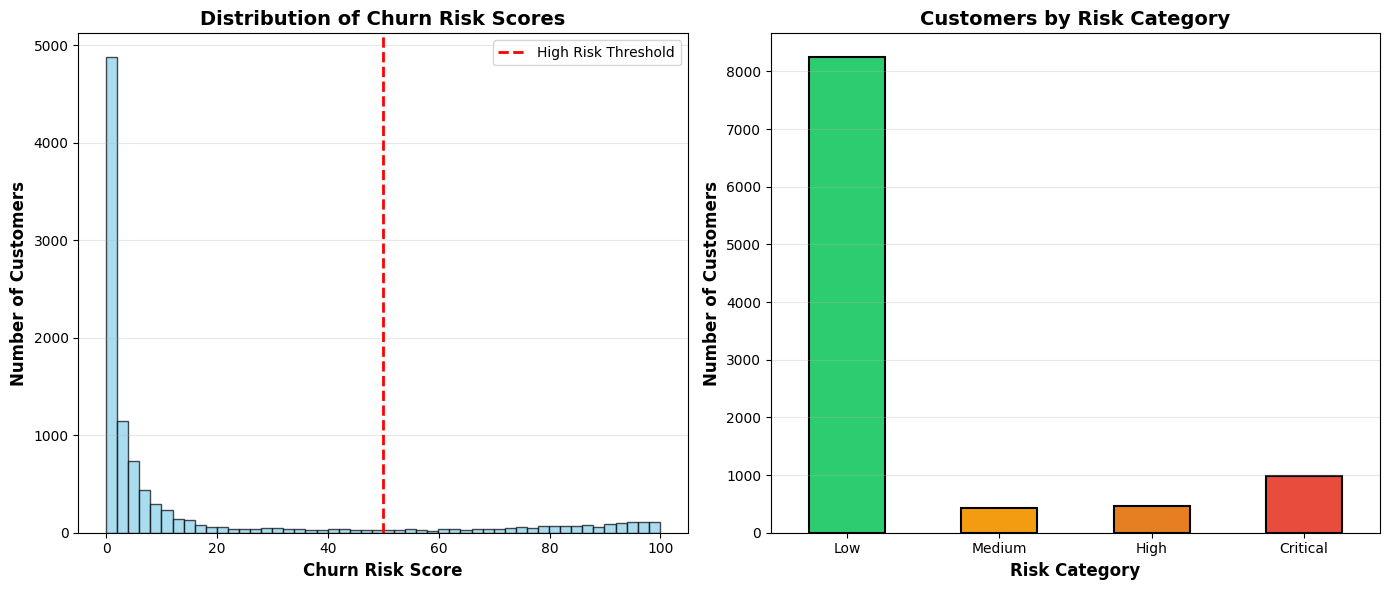

In [127]:
display(Markdown("**INDIVIDUAL CUSTOMER RISK SCORING**"))
print("Objective: Assign each customer a churn risk score (0-100)")


# Random Forest(since identified as best model) to score all customers
X_all = df[all_features]
churn_probabilities = rf_model.predict_proba(X_all)[:, 1]
df['Churn_Risk_Score'] = (churn_probabilities * 100).round(2)
df['Risk_Category'] = pd.cut(df['Churn_Risk_Score'], 
                             bins=[0, 25, 50, 75, 100],
                             labels=['Low', 'Medium', 'High', 'Critical'])

print("\n")
display(Markdown("**Risk Distribution:**"))

risk_dist = df['Risk_Category'].value_counts().sort_index()
for category, count in risk_dist.items():
    pct = (count / len(df)) * 100
    print(f"   {category:12} {count:>6,} customers ({pct:>5.1f}%)")

print("\n")
display(Markdown("**Top 10 highest risk customers:**"))
high_risk = df.nlargest(10, 'Churn_Risk_Score')[
    ['CLIENTNUM', 'Churn_Risk_Score', 'Total_Trans_Ct', 
     'Months_Inactive_12_mon', 'Attrition_Flag']
]
print(high_risk.to_string(index=False))


print("\n")
display(Markdown("**Top 10 lowest risk customers:**"))
low_risk = df.nsmallest(10, 'Churn_Risk_Score')[
    ['CLIENTNUM', 'Churn_Risk_Score', 'Total_Trans_Ct', 
     'Months_Inactive_12_mon', 'Attrition_Flag']
]
print(low_risk.to_string(index=False))


print("\n")
display(Markdown("**Visualizations for risk distribution**"))
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(df['Churn_Risk_Score'], bins=50, color='skyblue', 
         edgecolor='black', alpha=0.7)
plt.xlabel('Churn Risk Score', fontsize=12, fontweight='bold')
plt.ylabel('Number of Customers', fontsize=12, fontweight='bold')
plt.title('Distribution of Churn Risk Scores', 
          fontsize=14, fontweight='bold')
plt.axvline(x=50, color='red', linestyle='--', linewidth=2, label='High Risk Threshold')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
risk_dist.plot(kind='bar', color=['#2ecc71', '#f39c12', '#e67e22', '#e74c3c'],
               edgecolor='black', linewidth=1.5)
plt.xlabel('Risk Category', fontsize=12, fontweight='bold')
plt.ylabel('Number of Customers', fontsize=12, fontweight='bold')
plt.title('Customers by Risk Category', 
          fontsize=14, fontweight='bold')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [152]:
display(Markdown("**FINAL ANALYSIS SUMMARY & BUSINESS RECOMMENDATIONS**"))

display(Markdown("**Analysis Question:**"))
print("What factors cause credit card customers to churn and can we identify at risk customers before they leave? \n")

display(Markdown("**Answer found using the analysis:**"))
print("Yes, We identified the factors cause credit card customers to churnand according to that we can predict churn with high accuracy \n")


display(Markdown("**📊 Model Performance:**"))
print(f"   • Best Model: Random Forest")
print(f"   • Accuracy: {accuracy_rf*100:.2f}%")
print(f"   • AUC Score: {auc_rf:.4f}")
print(f"   • We can identify {recall*100:.0f}% of customers who will churn \n")

display(Markdown("**🔍 TOP 5 Churn Factors in the order of importance:**"))
for i, row in feature_importance_rf.head(5).iterrows():
    print(f"  {row['Feature']} ({row['Importance']*100:.1f}% importance)")
    
print("\n")
display(Markdown("**👥 Customer Segmentation:**"))
print(f"   • Identified {len(segment_analysis)} distinct risk segments")
highest_risk_seg = segment_analysis['Churn_Rate'].idxmax()
highest_risk_rate = segment_analysis.loc[highest_risk_seg, 'Churn_Rate']
highest_risk_size = int(segment_analysis.loc[highest_risk_seg, 'Segment_Size'])
print(f"   • Highest risk: Segment {highest_risk_seg} ({highest_risk_rate:.1f}% churn, {highest_risk_size:,} customers)")

critical_count = (df['Risk_Category'] == 'Critical').sum()
high_count = (df['Risk_Category'] == 'High').sum()
print(f"At risk customers:")
print(f"   • Critical Risk: {critical_count:,} customers")
print(f"   • High Risk: {high_count:,} customers")
print(f"   • Total Priority: {critical_count + high_count:,} customers need immediate attention")

print ("\n")
display(Markdown("**💼 BUSINESS RECOMMENDATIONS:**"))

print("1. Immediate Actions (Next 30 Days):")
print("   • Contact all Critical & High risk customers ({:,} total)".format(critical_count + high_count))
print("   • Offer retention incentives (fee waivers, rewards bonuses)")
print("   • Assign relationship managers to top 500 at-risk accounts")

print("\n2. Monitoring and Prevention:")
print("   • Flag customers with >3 months inactivity")
print("   • Alert when transaction count drops >30%")
print("   • Track engagement score monthly")

print("\n3. Product Stategies:")
print("   • Cross-sell additional products (current avg: 3.5, target: 5+)")
print("   • Incentivize transaction frequency (rewards per transaction)")
print("   • Re-engagement campaigns for inactive customers")

print("\n4. Implement Predictive System:")
print("   • Deploy Random Forest model in production")
print("   • Score all customers monthly")
print("   • Automate alerts for risk score changes")

print("\n5. Expected Impact:")
potential_saves = int(critical_count * 0.3)  # 30% save rate
revenue_per_customer = 500  # assumed annual revenue
potential_revenue = potential_saves * revenue_per_customer
print(f"   • If we save 30% of at-risk customers: {potential_saves:,} customers")
print(f"   • Potential revenue protected: ${potential_revenue:,}")

**FINAL ANALYSIS SUMMARY & BUSINESS RECOMMENDATIONS**

**Analysis Question:**

What factors cause credit card customers to churn and can we identify at risk customers before they leave? 



**Answer found using the analysis:**

Yes, We identified the factors cause credit card customers to churnand according to that we can predict churn with high accuracy 



**📊 Model Performance:**

   • Best Model: Random Forest
   • Accuracy: 93.88%
   • AUC Score: 0.9755
   • We can identify 70% of customers who will churn 



**🔍 TOP 5 Churn Factors in the order of importance:**

  Total_Trans_Amt (18.4% importance)
  Total_Trans_Ct (15.8% importance)
  Total_Revolving_Bal (11.3% importance)
  Engagement_Score (8.2% importance)
  Avg_Utilization_Ratio (7.9% importance)




**👥 Customer Segmentation:**

   • Identified 4 distinct risk segments
   • Highest risk: Segment 0 (40.0% churn, 3,062 customers)
At risk customers:
   • Critical Risk: 989 customers
   • High Risk: 464 customers
   • Total Priority: 1,453 customers need immediate attention




**💼 BUSINESS RECOMMENDATIONS:**

1. Immediate Actions (Next 30 Days):
   • Contact all Critical & High risk customers (1,453 total)
   • Offer retention incentives (fee waivers, rewards bonuses)
   • Assign relationship managers to top 500 at-risk accounts

2. Monitoring and Prevention:
   • Flag customers with >3 months inactivity
   • Alert when transaction count drops >30%
   • Track engagement score monthly

3. Product Stategies:
   • Cross-sell additional products (current avg: 3.5, target: 5+)
   • Incentivize transaction frequency (rewards per transaction)
   • Re-engagement campaigns for inactive customers

4. Implement Predictive System:
   • Deploy Random Forest model in production
   • Score all customers monthly
   • Automate alerts for risk score changes

5. Expected Impact:
   • If we save 30% of at-risk customers: 296 customers
   • Potential revenue protected: $148,000
